# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

### Set up the ResNet20 Architecture

1. Starting LR 0.01
2. No L1 Regualrization
3. L2 Regularization: 1e-4
4. Data Augmentation: Random crop, horizontal flip, random rotation
5. No Batch Normalization
2. ReLU Activation Function
3. Other parameters set to default

In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# import necessary dependencies
import argparse
import os, sys
import time
import PIL
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
from tools.cutout.util.cutout import Cutout

print('Architecture List:')
print(torch.cuda.get_arch_list())
print('Current Devices:')
torch.cuda.set_device(4) 
print(torch.cuda.current_device())

Architecture List:
['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']
Current Devices:
4


In [3]:
# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)   
        return out

In [7]:
# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
summary(net, (3,32,32))

Run on GPU...


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

## Training Original CIFAR-10

Run on GPU...
Files already downloaded and verified
Files already downloaded and verified
==> Training starts!
Epoch 0:
Training loss: 1.6899, Training accuracy: 0.3667
Validation loss: 1.6798, Validation accuracy: 0.4356
Elapsed 10.80
Saving ...

Epoch 1:
Training loss: 1.2503, Training accuracy: 0.5441
Validation loss: 1.2590, Validation accuracy: 0.5768
Elapsed 10.58
Saving ...

Epoch 2:
Training loss: 1.0281, Training accuracy: 0.6303
Validation loss: 1.0702, Validation accuracy: 0.6227
Elapsed 11.00
Saving ...

Epoch 3:
Training loss: 0.8922, Training accuracy: 0.6863
Validation loss: 1.1792, Validation accuracy: 0.6193
Elapsed 10.64

Epoch 4:
Training loss: 0.8136, Training accuracy: 0.7165
Validation loss: 1.1501, Validation accuracy: 0.6138
Elapsed 10.50

Epoch 5:
Training loss: 0.7679, Training accuracy: 0.7325
Validation loss: 1.2769, Validation accuracy: 0.6091
Elapsed 11.12

Epoch 6:
Training loss: 0.7388, Training accuracy: 0.7438
Validation loss: 0.9989, Validation accura

Training loss: 0.2478, Training accuracy: 0.9157
Validation loss: 0.3194, Validation accuracy: 0.8988
Elapsed 10.85
Saving ...

Epoch 62:
Training loss: 0.2459, Training accuracy: 0.9171
Validation loss: 0.3724, Validation accuracy: 0.8751
Elapsed 11.11

Epoch 63:
Training loss: 0.2471, Training accuracy: 0.9149
Validation loss: 0.3462, Validation accuracy: 0.8874
Elapsed 10.96

Epoch 64:
Training loss: 0.2451, Training accuracy: 0.9157
Validation loss: 0.3683, Validation accuracy: 0.8797
Elapsed 11.43

Epoch 65:
Training loss: 0.2485, Training accuracy: 0.9142
Validation loss: 0.3895, Validation accuracy: 0.8739
Elapsed 11.37

Epoch 66:
Training loss: 0.2445, Training accuracy: 0.9155
Validation loss: 0.3401, Validation accuracy: 0.8854
Elapsed 11.26

Epoch 67:
Training loss: 0.2462, Training accuracy: 0.9155
Validation loss: 0.4475, Validation accuracy: 0.8572
Elapsed 12.76

Epoch 68:
Training loss: 0.2471, Training accuracy: 0.9153
Validation loss: 0.3458, Validation accuracy: 0.886

Training loss: 0.0921, Training accuracy: 0.9708
Validation loss: 0.2874, Validation accuracy: 0.9131
Elapsed 12.90

Epoch 125:
Training loss: 0.0920, Training accuracy: 0.9709
Validation loss: 0.2805, Validation accuracy: 0.9146
Elapsed 12.10

Epoch 126:
Training loss: 0.0908, Training accuracy: 0.9712
Validation loss: 0.2742, Validation accuracy: 0.9151
Elapsed 12.74

Epoch 127:
Training loss: 0.0949, Training accuracy: 0.9697
Validation loss: 0.2723, Validation accuracy: 0.9154
Elapsed 13.49

Epoch 128:
Training loss: 0.0902, Training accuracy: 0.9719
Validation loss: 0.2882, Validation accuracy: 0.9132
Elapsed 12.51

Epoch 129:
Training loss: 0.0901, Training accuracy: 0.9715
Validation loss: 0.2845, Validation accuracy: 0.9131
Elapsed 12.74

Epoch 130:
Training loss: 0.0898, Training accuracy: 0.9713
Validation loss: 0.2831, Validation accuracy: 0.9116
Elapsed 12.13

Epoch 131:
Training loss: 0.0902, Training accuracy: 0.9706
Validation loss: 0.2815, Validation accuracy: 0.9152
El

Training loss: 0.0558, Training accuracy: 0.9847
Validation loss: 0.2750, Validation accuracy: 0.9190
Elapsed 13.13

Epoch 188:
Training loss: 0.0550, Training accuracy: 0.9840
Validation loss: 0.2734, Validation accuracy: 0.9193
Elapsed 13.03

Epoch 189:
Training loss: 0.0552, Training accuracy: 0.9838
Validation loss: 0.2730, Validation accuracy: 0.9188
Elapsed 12.73

Epoch 190:
Training loss: 0.0578, Training accuracy: 0.9833
Validation loss: 0.2770, Validation accuracy: 0.9180
Elapsed 13.48

Epoch 191:
Training loss: 0.0545, Training accuracy: 0.9844
Validation loss: 0.2768, Validation accuracy: 0.9179
Elapsed 13.78

Epoch 192:
Training loss: 0.0558, Training accuracy: 0.9836
Validation loss: 0.2726, Validation accuracy: 0.9196
Elapsed 13.36

Epoch 193:
Training loss: 0.0560, Training accuracy: 0.9831
Validation loss: 0.2755, Validation accuracy: 0.9182
Elapsed 14.00

Epoch 194:
Training loss: 0.0534, Training accuracy: 0.9845
Validation loss: 0.2776, Validation accuracy: 0.9169
El

/tmp/ipykernel_3767325/1213436719.py:256: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURES_FOLDER+MODELNAME+"_loss.png", quality=95, dpi=500)


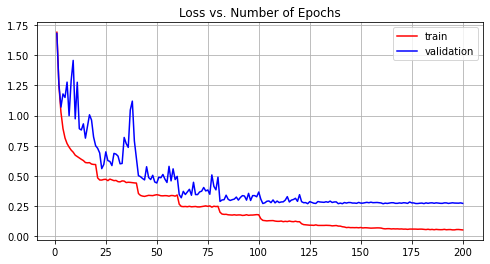

/tmp/ipykernel_3767325/1213436719.py:265: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURES_FOLDER+MODELNAME+"_acc.png", quality=95, dpi=500)


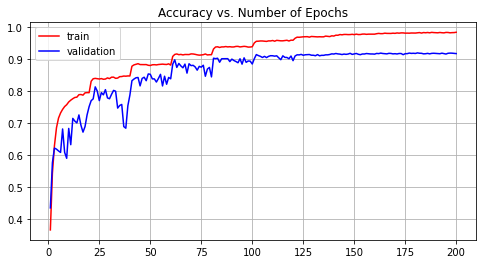

In [25]:
#############################################
# Parameters

# a few arguments, do NOT change these
DATA_ROOT         = "./data"
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER    = "savedFiles/saved_figures/"
# name of the saved model
MODELNAME         = "resnet20_original"

# random seed
random.seed(10)

# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)

# start the training/validation process
best_val_acc          = 0
current_learning_rate = INITIAL_LR
epochs                = np.linspace(1,EPOCHS,EPOCHS)

# lists for saving training and validation accuracy and loss
base_train_avg_loss = []
base_train_avg_acc  = []
base_valid_avg_loss = []
base_valid_avg_acc  = []

# Step 0: Model Definition

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
net = torch.nn.DataParallel(net, device_ids = [4,5]).cuda()

# Step 1: Preprocessing Function

# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=15, interpolation=InterpolationMode.BILINEAR),
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(0.5),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# as per lecture instructions, data augmentation is only enabled in the 
# training process. It is recommended not to perform data augmentation on 
# validation or test dataset.

transform_val = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Step 2: Set up dataset and dataloader

# construct dataset
train_set = datasets.CIFAR10(
    root=DATA_ROOT, 
    train=True, 
    download=True,
    transform=transform_train,
)
val_set = datasets.CIFAR10(
    root=DATA_ROOT, 
    train=False, 
    download=True,
    transform=transform_val,
)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

#Step 3: Set up the loss function and optimizer

# create loss function
criterion = nn.CrossEntropyLoss().to(device)
# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

# Step 4: Start the training process.
writer = SummaryWriter()
print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    start = time.time()
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    #######################
    # switch to train mode
    net.train()
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (images, targets) in enumerate(train_loader):
        ####################################
        
        # copy inputs to device
        images = images.to(device)
        targets = targets.to(device)
        
        # compute the output and loss
        outputs = net(images)
        loss = criterion(outputs, targets)
        
        # zero the gradient
        optimizer.zero_grad()        
        
        # backpropagation
        loss.backward()      
        
        # apply gradient and update the weights
        optimizer.step()         
        
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        # Append to totals
        total_examples += targets.shape[0]
        train_loss += loss
        correct_examples += correct.item()
        ####################################
                
    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_train_loss, avg_train_acc))
   
    # append to list
    base_train_avg_loss.append(avg_train_loss)
    base_train_avg_acc.append(avg_train_acc)

    # Validate on the validation dataset
    #######################
    # switch to eval mode
    net.eval()
    
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader):
            ####################################
            # copy inputs to device
            images = images.to(device)
            targets = targets.to(device)            
            
            # compute the output and loss
            outputs = net(images)
            loss = criterion(outputs, targets)
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()            

            # Append to totals
            total_examples += targets.shape[0]
            val_loss += loss
            correct_examples += correct.item()

            ####################################

    avg_validation_loss = val_loss / len(val_loader)
    avg_validation_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_validation_loss, avg_validation_acc))
    
    elapsed = time.time() - start
    elapsed_timeList.append(elapsed)
    print("Elapsed {:.2f}".format(elapsed))

    writer.add_scalars('loss', {'Loss/train'     : avg_train_loss,
                                'Loss/validation': avg_validation_loss},i)
    writer.add_scalars('accuracy', {'Acc/train'      : avg_train_acc,
                                    'Acc/validation' :avg_validation_acc}, i)                                            
    writer.add_scalar('Train/Time', elapsed, i)                                        

    # append to list
    base_valid_avg_loss.append(avg_validation_loss)
    base_valid_avg_acc.append(avg_validation_acc)

    # save the model checkpoint
    if avg_validation_acc > best_val_acc:
        best_val_acc = avg_validation_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, MODELNAME+".pth"))
        torch.save(net.module.state_dict(), CHECKPOINT_FOLDER+MODELNAME+'.pt')
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

torch.save(net.module.state_dict(), CHECKPOINT_FOLDER+MODELNAME+'.pt')
#############################################
base_train_avg_loss = [np.float(base_train_avg_loss[i].cpu().detach().numpy()) for i in range(len(base_train_avg_loss))]
base_valid_avg_loss = [np.float(base_valid_avg_loss[i].cpu().detach().numpy()) for i in range(len(base_valid_avg_loss))]
#############################################
plt.figure(figsize=(8,4))
plt.plot(epochs, base_train_avg_loss, color='red')
plt.plot(epochs, base_valid_avg_loss, color='blue')
plt.legend(['train','validation'])
plt.grid()
plt.title('Loss vs. Number of Epochs')
plt.savefig(FIGURES_FOLDER+MODELNAME+"_loss.png", quality=95, dpi=500)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, base_train_avg_acc, color='red')
plt.plot(epochs, base_valid_avg_acc, color='blue')
plt.legend(['train','validation'])
plt.grid()
plt.title('Accuracy vs. Number of Epochs')
plt.savefig(FIGURES_FOLDER+MODELNAME+"_acc.png", quality=95, dpi=500)
plt.show()

## Test on CIFAR10

In [5]:
def test_CIFAR10(net):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss()

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    val_loss = test_loss / num_val_steps
    print("Test Loss=%.4f, Test accuracy=%.4f" % (val_loss, val_acc))
    
    return val_loss, val_acc

net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
#net = torch.nn.DataParallel(net, device_ids = [0]).cuda()
net.load_state_dict(torch.load("/home/saman/sharedFolder/ECE661/Project/savedFiles/saved_models/resnet20_original.pt",map_location='cuda:0'))
val_loss, val_acc = test_CIFAR10(net)

np.save("/home/saman/sharedFolder/ECE661/Project/savedFiles/saved_NPYs/resnet20_original/val_acc.npy"  ,val_acc)
np.save("/home/saman/sharedFolder/ECE661/Project/savedFiles/saved_NPYs/resnet20_original/test_loss.npy",val_loss)

Files already downloaded and verified
Test Loss=0.2729, Test accuracy=0.9183


## Test on CIFAR10-C
### 19 different corrputed datasets

In [6]:
corrupted_data_type = ['brightness','contrast','defocus_blur','elastic_transform','fog','frost','gaussian_blur',
                       'gaussian_noise','glass_blur','impulse_noise','jpeg_compression','motion_blur','pixelate',
                       'saturate','shot_noise','snow','spatter','speckle_noise','zoom_blur']

'''
This part of the code is adopted from
https://github.com/tanimutomo/cifar10-c-eval/blob/b4b30257ddbd737c64bc3d2e961a2c47238b5249/src/dataset.py
'''

class CIFAR10C(datasets.VisionDataset):
    def __init__(self, root :str, name :str,transform=None, target_transform=None):
        super(CIFAR10C, self).__init__(root, transform=transform,target_transform=target_transform
        )
        data_path = os.path.join(root, name + '.npy')
        target_path = os.path.join(root, 'labels.npy')
        
        self.data = np.load(data_path)
        self.targets = np.load(target_path)
        
    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            targets = self.target_transform(targets)
            
        return img, targets
    
    def __len__(self):
        return len(self.data)

def test_CIFAR10C(net,corruption_to_use='glass_blur'):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = CIFAR10C(root='/home/saman/sharedFolder/ECE661/Project/data/CIFAR10-C/',name=corruption_to_use, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss()

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    val_loss = test_loss / num_val_steps
    print("Test Loss=%.4f, Test accuracy=%.4f" % (val_loss, val_acc))
        
    return val_loss, val_acc
    
net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
net.load_state_dict(torch.load("/home/saman/sharedFolder/ECE661/Project/savedFiles/saved_models/resnet20_original.pt",map_location='cuda:0'))

val_lossList = []
val_accList  = []

for corruption_i in corrupted_data_type:
    print('Corruption type:{}'.format(corruption_i))
    val_loss, val_acc = test_CIFAR10C(net,corruption_to_use=corruption_i)
    val_lossList.append(val_loss)
    val_accList.append(val_acc)
    
np.save("/home/saman/sharedFolder/ECE661/Project/savedFiles/saved_NPYs/resnet20_original/val_acc_C.npy"  ,val_accList)
np.save("/home/saman/sharedFolder/ECE661/Project/savedFiles/saved_NPYs/resnet20_original/test_loss_C.npy",val_lossList)

Corruption type:brightness
Test Loss=0.3409, Test accuracy=0.9008
Corruption type:contrast
Test Loss=1.0623, Test accuracy=0.7457
Corruption type:defocus_blur
Test Loss=0.5191, Test accuracy=0.8688
Corruption type:elastic_transform
Test Loss=0.5406, Test accuracy=0.8510
Corruption type:fog
Test Loss=0.6089, Test accuracy=0.8439
Corruption type:frost
Test Loss=1.1816, Test accuracy=0.7161
Corruption type:gaussian_blur
Test Loss=0.9475, Test accuracy=0.8022
Corruption type:gaussian_noise
Test Loss=3.3059, Test accuracy=0.3665
Corruption type:glass_blur
Test Loss=2.1079, Test accuracy=0.5127
Corruption type:impulse_noise
Test Loss=1.8001, Test accuracy=0.5811
Corruption type:jpeg_compression
Test Loss=0.8689, Test accuracy=0.7656
Corruption type:motion_blur
Test Loss=0.8622, Test accuracy=0.7830
Corruption type:pixelate
Test Loss=1.1423, Test accuracy=0.7230
Corruption type:saturate
Test Loss=0.4675, Test accuracy=0.8708
Corruption type:shot_noise
Test Loss=2.6153, Test accuracy=0.4752
Co

Files already downloaded and verified
Files already downloaded and verified
torch.Size([20, 3, 32, 32])


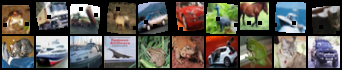

In [11]:
from tools.cutout.util.cutout import Cutout

cutout_n_holes   = 2      # Number of patches to cut out of each image.
cutout_length    = 4      # The length (in pixels) of each square patch.

# a few arguments, do NOT change these
DATA_ROOT         = "./data"

# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=15, interpolation=InterpolationMode.BILINEAR),
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(0.5),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
])
transform_train.transforms.append(Cutout(n_holes=cutout_n_holes, length=cutout_length))

# as per lecture instructions, data augmentation is only enabled in the 
# training process. It is recommended not to perform data augmentation on 
# validation or test dataset.

transform_val = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

# construct dataset
train_set = datasets.CIFAR10(
    root=DATA_ROOT, 
    train=True, 
    download=True,
    transform=transform_train,
)
val_set = datasets.CIFAR10(
    root=DATA_ROOT, 
    train=False, 
    download=True,
    transform=transform_val,
)

imgs = torch.stack((*[train_set[i][0] for i in range(10)],
                        *[val_set[i][0] for i in range(10)]))

grid = torchvision.utils.make_grid(imgs, nrow=10)

print(imgs.shape)

grid = torchvision.utils.make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

In [12]:
def run_cutout(cutout_n_holes, cutout_length):

    #############################################
    # Parameters

    # a few arguments, do NOT change these
    DATA_ROOT         = "./data"
    # the folder where the trained model is saved
    CHECKPOINT_FOLDER = "savedFiles/saved_models/"
    # the folder where the figures are saved
    FIGURES_FOLDER    = "savedFiles/saved_figures/"
    # name of the saved model
    MODELNAME         = "resnet20_cutout_%d_%d" %(cutout_n_holes, cutout_length)

    # random.seed

    random.seed(10)

    # hyperparameters, do NOT change right now
    TRAIN_BATCH_SIZE = 256    # training batch size
    VAL_BATCH_SIZE   = 100    # validation batch size
    INITIAL_LR       = 0.1    # initial learning rate
    MOMENTUM         = 0.9    # momentum for optimizer
    REG              = 1e-3   # L2 regularization strength
    EPOCHS           = 200    # total number of training epochs
    DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
    DECAY            = 0.5    # parameter for LR schedule (decay multiplier)

    # start the training/validation process
    best_val_acc          = 0
    current_learning_rate = INITIAL_LR
    epochs                = np.linspace(1,EPOCHS,EPOCHS)

    # lists for saving training and validation accuracy and loss
    base_train_avg_loss = []
    base_train_avg_acc  = []
    base_valid_avg_loss = []
    base_valid_avg_acc  = []
    elapsed_timeList    = []

    # Step 0: Model Definition

    # GPU check                
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device =='cuda':
        print("Run on GPU...")
    else:
        print("Run on CPU...")

    net = ResNet(ResBlock, [3, 3, 3]).to(device)
    net = net.to(device)
    net = torch.nn.DataParallel(net, device_ids = [4,5]).cuda()

    # Step 1: Preprocessing Function

    # specify preprocessing function
    transform_train = transforms.Compose([
        transforms.RandomRotation(degrees=15, interpolation=InterpolationMode.BILINEAR),
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_train.transforms.append(Cutout(n_holes=cutout_n_holes, length=cutout_length))

    # as per lecture instructions, data augmentation is only enabled in the 
    # training process. It is recommended not to perform data augmentation on 
    # validation or test dataset.

    transform_val = transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Step 2: Set up dataset and dataloader

    # construct dataset
    train_set = datasets.CIFAR10(
        root=DATA_ROOT, 
        train=True, 
        download=True,
        transform=transform_train,
    )
    val_set = datasets.CIFAR10(
        root=DATA_ROOT, 
        train=False, 
        download=True,
        transform=transform_val,
    )

    # construct dataloader
    train_loader = DataLoader(
        train_set, 
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=4
    )
    val_loader = DataLoader(
        val_set, 
        batch_size=VAL_BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
        num_workers=4
    )

    #Step 3: Set up the loss function and optimizer

    # create loss function
    criterion = nn.CrossEntropyLoss().to(device)
    # Add optimizer
    optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

    # Step 4: Start the training process.
    writer = SummaryWriter()
    print("==> Training starts!")
    print("="*50)
    for i in range(0, EPOCHS):
        start = time.time()
        # handle the learning rate scheduler.
        if i % DECAY_EPOCHS == 0 and i != 0:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            print("Current learning rate has decayed to %f" %current_learning_rate)

        #######################
        # switch to train mode
        net.train()
        #######################

        print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want

        # Train the model for 1 epoch.
        for batch_idx, (images, targets) in enumerate(train_loader):
            ####################################

            # copy inputs to device
            images = images.to(device)
            targets = targets.to(device)

            # compute the output and loss
            outputs = net(images)
            loss = criterion(outputs, targets)

            # zero the gradient
            optimizer.zero_grad()        

            # backpropagation
            loss.backward()      

            # apply gradient and update the weights
            optimizer.step()         

            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            # Append to totals
            total_examples += targets.shape[0]
            train_loss += loss
            correct_examples += correct.item()
            ####################################

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = correct_examples / total_examples
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_train_loss, avg_train_acc))

        # append to list
        base_train_avg_loss.append(avg_train_loss)
        base_train_avg_acc.append(avg_train_acc)

        # Validate on the validation dataset
        #######################
        # switch to eval mode
        net.eval()

        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0

        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(val_loader):
                ####################################
                # copy inputs to device
                images = images.to(device)
                targets = targets.to(device)            

                # compute the output and loss
                outputs = net(images)
                loss = criterion(outputs, targets)
                # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()            

                # Append to totals
                total_examples += targets.shape[0]
                val_loss += loss
                correct_examples += correct.item()

                ####################################

        avg_validation_loss = val_loss / len(val_loader)
        avg_validation_acc = correct_examples / total_examples
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_validation_loss, avg_validation_acc))

        elapsed = time.time() - start
        elapsed_timeList.append(elapsed)
        print("Elapsed {:.2f}".format(elapsed))

        writer.add_scalars('loss', {'Loss/train'     : avg_train_loss,
                                    'Loss/validation': avg_validation_loss},i)
        writer.add_scalars('accuracy', {'Acc/train'      : avg_train_acc,
                                        'Acc/validation' :avg_validation_acc}, i)                                            
        writer.add_scalar('Train/Time', elapsed, i)

        # append to list
        base_valid_avg_loss.append(avg_validation_loss)
        base_valid_avg_acc.append(avg_validation_acc)

        # save the model checkpoint
        if avg_validation_acc > best_val_acc:
            best_val_acc = avg_validation_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
               os.makedirs(CHECKPOINT_FOLDER)
            print("Saving ...")
            state = {'state_dict': net.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, MODELNAME+".pth"))
            torch.save(net.module.state_dict(), CHECKPOINT_FOLDER+MODELNAME+'.pt')

        print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

    torch.save(net.module.state_dict(), CHECKPOINT_FOLDER+MODELNAME+'.pt')
    #############################################
    base_train_avg_loss = [np.float(base_train_avg_loss[i].cpu().detach().numpy()) for i in range(len(base_train_avg_loss))]
    base_valid_avg_loss = [np.float(base_valid_avg_loss[i].cpu().detach().numpy()) for i in range(len(base_valid_avg_loss))]
    #############################################
    plt.figure(figsize=(8,4))
    plt.plot(epochs, base_train_avg_loss, color='red')
    plt.plot(epochs, base_valid_avg_loss, color='blue')
    plt.legend(['train','validation'])
    plt.grid()
    plt.title('Loss vs. Number of Epochs')
    plt.savefig(FIGURES_FOLDER+MODELNAME+"_loss.png", quality=95, dpi=500)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs, base_train_avg_acc, color='red')
    plt.plot(epochs, base_valid_avg_acc, color='blue')
    plt.legend(['train','validation'])
    plt.grid()
    plt.title('Accuracy vs. Number of Epochs')
    plt.savefig(FIGURES_FOLDER+MODELNAME+"_acc.png", quality=95, dpi=500)

    plt.show()

**************************************************
ResNet20 w/ Cutout
Number of holes: 1
Length of holes: 4


Run on GPU...
Files already downloaded and verified
Files already downloaded and verified
==> Training starts!
Epoch 0:
Training loss: 1.7272, Training accuracy: 0.3483
Validation loss: 1.6596, Validation accuracy: 0.4012
Elapsed 13.50
Saving ...

Epoch 1:
Training loss: 1.3083, Training accuracy: 0.5230
Validation loss: 1.6003, Validation accuracy: 0.4538
Elapsed 12.05
Saving ...

Epoch 2:
Training loss: 1.0756, Training accuracy: 0.6165
Validation loss: 2.0218, Validation accuracy: 0.4719
Elapsed 12.20
Saving ...

Epoch 3:
Training loss: 0.9197, Training accuracy: 0.6760
Validation loss: 1.3775, Validation accuracy: 0.5569
Elapsed 12.17
Saving ...

Epoch 4:
Training loss: 0.8420, Training accuracy: 0.7060
Validation loss: 1.0072, Validation accuracy: 0.6584
Elapsed 12.38
Saving ...

Epoch 5:
Training loss: 0.7843, Training accuracy: 0.7263
Validation loss: 1.0860, Validation 

Validation loss: 0.3147, Validation accuracy: 0.8935
Elapsed 12.57
Saving ...

Epoch 61:
Training loss: 0.2691, Training accuracy: 0.9077
Validation loss: 0.3379, Validation accuracy: 0.8876
Elapsed 12.57

Epoch 62:
Training loss: 0.2681, Training accuracy: 0.9083
Validation loss: 0.3526, Validation accuracy: 0.8840
Elapsed 13.09

Epoch 63:
Training loss: 0.2637, Training accuracy: 0.9101
Validation loss: 0.3631, Validation accuracy: 0.8799
Elapsed 13.20

Epoch 64:
Training loss: 0.2604, Training accuracy: 0.9110
Validation loss: 0.3601, Validation accuracy: 0.8808
Elapsed 13.73

Epoch 65:
Training loss: 0.2634, Training accuracy: 0.9088
Validation loss: 0.4130, Validation accuracy: 0.8625
Elapsed 12.91

Epoch 66:
Training loss: 0.2616, Training accuracy: 0.9101
Validation loss: 0.3514, Validation accuracy: 0.8835
Elapsed 12.40

Epoch 67:
Training loss: 0.2618, Training accuracy: 0.9101
Validation loss: 0.3761, Validation accuracy: 0.8771
Elapsed 12.73

Epoch 68:
Training loss: 0.2622,

Validation loss: 0.2833, Validation accuracy: 0.9094
Elapsed 13.66

Epoch 124:
Training loss: 0.1103, Training accuracy: 0.9638
Validation loss: 0.2966, Validation accuracy: 0.9081
Elapsed 13.79

Epoch 125:
Training loss: 0.1073, Training accuracy: 0.9656
Validation loss: 0.2804, Validation accuracy: 0.9134
Elapsed 15.60

Epoch 126:
Training loss: 0.1058, Training accuracy: 0.9656
Validation loss: 0.2793, Validation accuracy: 0.9142
Elapsed 15.89

Epoch 127:
Training loss: 0.1070, Training accuracy: 0.9651
Validation loss: 0.2747, Validation accuracy: 0.9139
Elapsed 14.73

Epoch 128:
Training loss: 0.1066, Training accuracy: 0.9656
Validation loss: 0.2871, Validation accuracy: 0.9109
Elapsed 14.64

Epoch 129:
Training loss: 0.1098, Training accuracy: 0.9637
Validation loss: 0.2915, Validation accuracy: 0.9105
Elapsed 13.34

Epoch 130:
Training loss: 0.1069, Training accuracy: 0.9655
Validation loss: 0.2783, Validation accuracy: 0.9122
Elapsed 13.82

Epoch 131:
Training loss: 0.1069, Tr

Validation loss: 0.2769, Validation accuracy: 0.9163
Elapsed 16.73

Epoch 187:
Training loss: 0.0711, Training accuracy: 0.9786
Validation loss: 0.2712, Validation accuracy: 0.9194
Elapsed 16.73

Epoch 188:
Training loss: 0.0692, Training accuracy: 0.9792
Validation loss: 0.2675, Validation accuracy: 0.9188
Elapsed 16.47

Epoch 189:
Training loss: 0.0694, Training accuracy: 0.9786
Validation loss: 0.2662, Validation accuracy: 0.9199
Elapsed 16.16
Saving ...

Epoch 190:
Training loss: 0.0710, Training accuracy: 0.9787
Validation loss: 0.2695, Validation accuracy: 0.9195
Elapsed 16.83

Epoch 191:
Training loss: 0.0693, Training accuracy: 0.9789
Validation loss: 0.2725, Validation accuracy: 0.9170
Elapsed 16.57

Epoch 192:
Training loss: 0.0721, Training accuracy: 0.9780
Validation loss: 0.2719, Validation accuracy: 0.9165
Elapsed 16.15

Epoch 193:
Training loss: 0.0680, Training accuracy: 0.9791
Validation loss: 0.2739, Validation accuracy: 0.9170
Elapsed 16.53

Epoch 194:
Training loss:

/tmp/ipykernel_3957926/4127757195.py:261: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURES_FOLDER+MODELNAME+"_loss.png", quality=95, dpi=500)


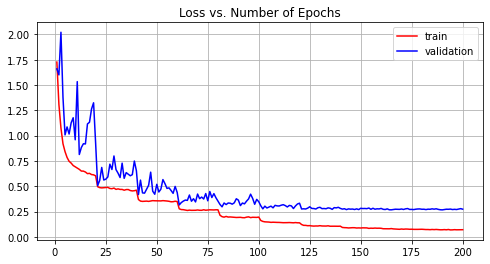

/tmp/ipykernel_3957926/4127757195.py:270: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(FIGURES_FOLDER+MODELNAME+"_acc.png", quality=95, dpi=500)


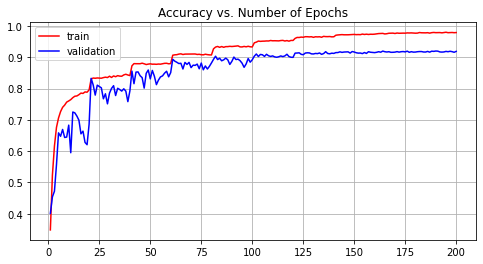

Files already downloaded and verified
Test Loss=0.2730, Test accuracy=0.9188
Corruption type:brightness
Test Loss=0.3430, Test accuracy=0.8993
Corruption type:contrast
Test Loss=1.1369, Test accuracy=0.7238
Corruption type:defocus_blur
Test Loss=0.4929, Test accuracy=0.8659
Corruption type:elastic_transform
Test Loss=0.5200, Test accuracy=0.8500
Corruption type:fog
Test Loss=0.6136, Test accuracy=0.8358
Corruption type:frost
Test Loss=1.3646, Test accuracy=0.6958
Corruption type:gaussian_blur
Test Loss=0.8895, Test accuracy=0.7891
Corruption type:gaussian_noise
Test Loss=3.5838, Test accuracy=0.3702
Corruption type:glass_blur
Test Loss=2.3999, Test accuracy=0.4908
Corruption type:impulse_noise
Test Loss=1.9581, Test accuracy=0.5785
Corruption type:jpeg_compression
Test Loss=0.8871, Test accuracy=0.7585
Corruption type:motion_blur
Test Loss=0.8147, Test accuracy=0.7810
Corruption type:pixelate
Test Loss=0.9710, Test accuracy=0.7508
Corruption type:saturate
Test Loss=0.4601, Test accurac

Training loss: 0.3878, Training accuracy: 0.8660
Validation loss: 0.4737, Validation accuracy: 0.8430
Elapsed 16.05

Epoch 51:
Training loss: 0.3953, Training accuracy: 0.8640
Validation loss: 0.5174, Validation accuracy: 0.8308
Elapsed 16.61

Epoch 52:
Training loss: 0.3852, Training accuracy: 0.8670
Validation loss: 0.5990, Validation accuracy: 0.8077
Elapsed 16.84

Epoch 53:
Training loss: 0.3982, Training accuracy: 0.8629
Validation loss: 0.5382, Validation accuracy: 0.8267
Elapsed 17.04

Epoch 54:
Training loss: 0.3976, Training accuracy: 0.8620
Validation loss: 0.4187, Validation accuracy: 0.8573
Elapsed 15.75

Epoch 55:
Training loss: 0.3926, Training accuracy: 0.8657
Validation loss: 0.5076, Validation accuracy: 0.8351
Elapsed 15.82

Epoch 56:
Training loss: 0.3847, Training accuracy: 0.8665
Validation loss: 0.5612, Validation accuracy: 0.8143
Elapsed 15.90

Epoch 57:
Training loss: 0.3912, Training accuracy: 0.8663
Validation loss: 0.4657, Validation accuracy: 0.8454
Elapsed 1

Training loss: 0.1772, Training accuracy: 0.9398
Validation loss: 0.3194, Validation accuracy: 0.8949
Elapsed 16.51

Epoch 114:
Training loss: 0.1774, Training accuracy: 0.9395
Validation loss: 0.2874, Validation accuracy: 0.9051
Elapsed 16.70

Epoch 115:
Training loss: 0.1802, Training accuracy: 0.9378
Validation loss: 0.2959, Validation accuracy: 0.9034
Elapsed 16.37

Epoch 116:
Training loss: 0.1798, Training accuracy: 0.9387
Validation loss: 0.2954, Validation accuracy: 0.9018
Elapsed 16.62

Epoch 117:
Training loss: 0.1797, Training accuracy: 0.9392
Validation loss: 0.2959, Validation accuracy: 0.9026
Elapsed 16.86

Epoch 118:
Training loss: 0.1791, Training accuracy: 0.9384
Validation loss: 0.3152, Validation accuracy: 0.8975
Elapsed 17.07

Epoch 119:
Training loss: 0.1797, Training accuracy: 0.9398
Validation loss: 0.2981, Validation accuracy: 0.9036
Elapsed 16.39

Current learning rate has decayed to 0.001563
Epoch 120:
Training loss: 0.1576, Training accuracy: 0.9467
Validatio

In [ ]:
corrupted_data_type = ['brightness','contrast','defocus_blur','elastic_transform','fog','frost','gaussian_blur',
                       'gaussian_noise','glass_blur','impulse_noise','jpeg_compression','motion_blur','pixelate',
                       'saturate','shot_noise','snow','spatter','speckle_noise','zoom_blur']

cutout_n_holesList = [1, 1, 1 , 2, 2, 2, 4, 4]
cutout_lengthList  = [2, 4, 8, 16, 2, 4, 8, 2, 4]

defaultPath = "/home/saman/sharedFolder/ECE661/Project/savedFiles/"

for i in range(len(cutout_n_holesList)):
    
    print("*"*50)
    print("ResNet20 w/ Cutout")
    print("Number of holes: %d" %cutout_n_holesList[i])
    print("Length of holes: %d" %cutout_lengthList[i])
    print("\n")
    
    # create a specific folder for results
    os.mkdir(defaultPath+"saved_NPYs/resnet20_cutout_%d_%d" %(cutout_n_holesList[i], cutout_lengthList[i]))
    savePath = defaultPath+"saved_NPYs/resnet20_cutout_%d_%d" %(cutout_n_holesList[i], cutout_lengthList[i])    
    # run ResNet20 w/ Cutout
    run_cutout(cutout_n_holesList[i], cutout_lengthList[i])
    # test on original CIFAR10 dataset
    net = ResNet(ResBlock, [3, 3, 3]).to(device)
    net = net.to(device)
    net.load_state_dict(torch.load(defaultPath+"saved_models/resnet20_cutout_%d_%d" %(cutout_n_holesList[i], cutout_lengthList[i]),map_location='cuda:0'))
    val_loss, val_acc = test_CIFAR10(net)
    # save
    np.save(savePath+"val_acc.npy"  ,val_acc)
    np.save(savePath+"test_loss.npy",val_loss)
    
    # test on corrupted CIFAR10 dataset
    net = ResNet(ResBlock, [3, 3, 3]).to(device)
    net = net.to(device)
    net.load_state_dict(torch.load(defaultPath+"saved_models/resnet20_cutout_%d_%d" %(cutout_n_holesList[i], cutout_lengthList[i]),map_location='cuda:0'))
    # empty lists for each run
    val_lossList = []
    val_accList  = []
    # for loop over all corrupted data types (19)
    for corruption_i in corrupted_data_type:
        print('Corruption type:{}'.format(corruption_i))
        val_loss, val_acc = test_CIFAR10C(net,corruption_to_use=corruption_i)
        val_lossList.append(val_loss)
        val_accList.append(val_acc)
    # save
    np.save(savePath+"val_acc_C.npy"  ,val_accList)
    np.save(savePath+"test_loss_C.npy",val_lossList)
    